I am trying a new approach to following along the notebooks.

Comment: code is commented for understanding - use later to re-write notebook

## IMDb

At Fast.ai we have introduced a new module called fastai.text which replaces the torchtext library that was used in our 2018 dl1 course. The fastai.text module also supersedes the fastai.nlp library but retains many of the key functions.

fastai.text contains all the text related functions we need  
html is used a little bit

In [2]:
from fastai.text import *
import html

The Fastai.text module introduces several custom tokens.

We need to download the IMDB large movie reviews from this site: http://ai.stanford.edu/~amaas/data/sentiment/
Direct link : [Link](http://ai.stanford.edu/~amaas/data/sentiment/aclImdb_v1.tar.gz) and untar it into the PATH location. We use pathlib which makes directory traveral a breeze.

BOS = 'xbos'
* a tag for the beginning of a sentence
* TODO figure out where this is used

FLD = 'xfld'
* a data field tag
* TODO figure out where this is used

PATH
* Pathlib path to data folder

In [3]:
BOS = 'xbos'  # beginning-of-sentence tag
FLD = 'xfld'  # data field tag

PATH=Path('data/aclImdb/')

## Standardize format

CLAS_PATH
* Pathlib to class folder (different than PATH)

LM_PATH
* Pathlib to the language model folder (different than PATH)

make directories for both path's using the pathlib objects

In [4]:
CLAS_PATH=Path('data/imdb_clas/')
CLAS_PATH.mkdir(exist_ok=True)

LM_PATH=Path('data/imdb_lm/')
LM_PATH.mkdir(exist_ok=True)

The imdb dataset has 3 classes. positive, negative and unsupervised(sentiment is unknown). 
There are 75k training reviews(12.5k pos, 12.5k neg, 50k unsup)
There are 25k validation reviews(12.5k pos, 12.5k neg & no unsup)

Refer to the README file in the imdb corpus for further information about the dataset.

CLASSES
* list of each folder name in aclImdb

def get_texts(path):
* create list for texts, and labels
* loop through i,label in CLASSES
* loop through each file in each folder using pathlib glob('*.*')
* open file - read file - append file to texts list - append idx to labels list
* return two numpy arrays - one for text - one for labels

trn_texts,trn_labels
* use get_texts on the train path

val_texts,val_labels
* use get_texts on test path

In [5]:
CLASSES = ['neg', 'pos', 'unsup']

def get_texts(path):
    texts,labels = [],[]
    for idx,label in enumerate(CLASSES):
        for fname in (path/label).glob('*.*'):
            texts.append(fname.open('r').read())
            labels.append(idx)
    return np.array(texts),np.array(labels)

trn_texts,trn_labels = get_texts(PATH/'train')
val_texts,val_labels = get_texts(PATH/'test')

verify that len of trn_texts is 75,000 and len of val_texts is 25,000

In [6]:
len(trn_texts),len(val_texts)

(75000, 25000)

column names for df are ['labels', 'text']

In [7]:
col_names = ['labels','text']

We use a random permutation np array to shuffle the text reviews.  
declare a numpy seed  
use np.random.permutations() and len() to create a trn_idx and val_idx


In [8]:
np.random.seed(42)
trn_idx = np.random.permutation(len(trn_texts))
val_idx = np.random.permutation(len(val_texts))

index into arrays to shuffle them

In [11]:
trn_texts = trn_texts[trn_idx]
val_texts = val_texts[val_idx]

trn_labels = trn_labels[trn_idx]
val_labels = val_labels[val_idx]

create a df_trn and a df_val in the order of {'text':texts, 'labels':labels}, columns=col_names

In [12]:
df_trn = pd.DataFrame({'text':trn_texts, 'labels':trn_labels}, columns=col_names)
df_val = pd.DataFrame({'text':val_texts, 'labels':val_labels}, columns=col_names)

The pandas dataframe is used to store text data in a newly evolving standard format of label followed by text columns. This was influenced by a paper by Yann LeCun (LINK REQUIRED). Fastai adopts this new format for NLP datasets. In the case of IMDB, there is only one text column.

use df_trn to create train.csv in CLAS_PATH by selecting all indices that aren't unsupervised [df_trn['labels']!=2, no header and no index  
use df_val to create test.csv in CLAS_PATH  


In [18]:
df_trn[df_trn['labels']!=2].to_csv(CLAS_PATH/'train.csv', header=False, index=False)
df_val.to_csv(CLAS_PATH/'test.csv', header=False, index=False)

open CLAS_PATH/classes.text and use the writelines function to write each class followed by a newline

neg  
pos  
unsup  

In [20]:
(CLAS_PATH/'classes.txt').open('w').writelines(f'{o}\n' for o in CLASSES)

We start by creating the data for the Language Model(LM). The LM's goal is to learn the structure of the english language. It learns language by trying to predict the next word given a set of previous words(ngrams). Since the LM does not classify reviews, the labels can be ignored.

The LM can benefit from all the textual data and there is no need to exclude the unsup/unclassified movie reviews.

We first concat all the train(pos/neg/unsup = **75k**) and test(pos/neg=**25k**) reviews into a big chunk of **100k** reviews. And then we use sklearn splitter to divide up the 100k texts into 90% training and 10% validation sets.

trn_texts,val_texts = sklearn.model_selection.train_test_split
* np.concatentate([trn_texts,val_texts])
* test_size = 0.1

In [21]:
trn_texts,val_texts = sklearn.model_selection.train_test_split(
    np.concatenate([trn_texts,val_texts]), test_size=0.1)

make sure to check lenght of trn_texts and val_texts

In [22]:
len(trn_texts), len(val_texts)

(90000, 10000)

write csv files to LM_PATH for train.csv and test.csv using pandas  
'labels' are only zeros 

In [24]:
df_trn = pd.DataFrame({'text':trn_texts, 'labels':[0]*len(trn_texts)}, columns=col_names)
df_val = pd.DataFrame({'text':val_texts, 'labels':[0]*len(val_texts)}, columns=col_names)

df_trn.to_csv(LM_PATH/'train.csv', header=False, index=False)
df_val.to_csv(LM_PATH/'test.csv', header=False, index=False)

## Language model tokens

In this section, we start cleaning up the messy text. There are 2 main activities we need to perform:

1. Clean up extra spaces, tab chars, new ln chars and other characters and replace them with standard ones
2. Use the awesome [spacy](http://spacy.io) library to tokenize the data. Since spacy does not provide a parallel/multicore version of the tokenizer, the fastai library adds this functionality. This parallel version uses all the cores of your CPUs and runs much faster than the serial version of the spacy tokenizer.

Tokenization is the process of splitting the text into separate tokens so that each token can be assigned a unique index. This means we can convert the text into integer indexes our models can use.

We use an appropriate chunksize as the tokenization process is memory intensive

chunksize of about 24000 is good

In [47]:
chunksize=24000

re1 = re.compile(r'  +')
* use re.compile to create a regular expression pattern object that can be used for substitutions
* TODO: understand the regular expression

use a long list of replacement rules to create a fixup function for text

def fixup(x):
* replace all the things
* use re1.sub to replace ' ' with html.unescape(x)

replacement_rules = [['#39;', "'"], ['amp;', '&'], ['#146;', "'"], ['nbsp;', ' '],
                     ['#36;', '$'], ['\\n', "\n"], ['quot;', "'"], ['<br />', "\n"],
                     ['\\"', '"'], ['<unk>','u_n'], [' @.@ ','.'], [' @-@ ','-'], ['\\', ' \\ ']]

re1 = re.compile(r'  +')

def fixup(x):
    x = x.replace('#39;', "'").replace('amp;', '&').replace('#146;', "'").replace(
        'nbsp;', ' ').replace('#36;', '$').replace('\\n', "\n").replace('quot;', "'").replace(
        '<br />', "\n").replace('\\"', '"').replace('<unk>','u_n').replace(' @.@ ','.').replace(
        ' @-@ ','-').replace('\\', ' \\ ')
    return re1.sub(' ', html.unescape(x))

def get_texts(df, n_lbls=1)
* gets the text from a dataframe and fixes it up - then tokenizes text and returns it
* n_lbls the number of labels - we will have 1 for imdb depicting neg, pos, or unsup
* create a numpy array of all the labels by indexing into the dataframe using .iloc and then setting the values to np.int64
* add f'\n{BOS} {FLD} 1 ' to all the strings in the df.
* use apply method to run fixup on each text of texts then extract values as string
* tokenize texts using Toeknizer().proc_all_mp(partition_by_cores(texts))
* return tok and the list of labels

In [166]:
def get_texts(df, n_lbls=1):
    labels = df.iloc[:,range(n_lbls)].values.astype(np.int64)
    texts = f'\n{BOS} {FLD} 1 ' + df[n_lbls].astype(str)
    for i in range(n_lbls+1, len(df.columns)): texts += f' {FLD} {i-n_lbls} ' + df[i].astype(str)
    texts = texts.apply(fixup).values.astype(str)

    tok = Tokenizer().proc_all_mp(partition_by_cores(texts))
    return tok, list(labels)

def get_all(df, nlbls)
* this function is getting all the text from a dataframe - we are making a language model so we should use all the text
* create empty lists for tok and labels
* loop over enumerated dataframe
* use get_texts to get a new list of tokens and list of labels
* append new tokens and labels to toka nd labels
* return tok and labels

In [167]:
def get_all(df, n_lbls):
    tok, labels = [], []
    for i, r in enumerate(df):
        print(i)
        tok_, labels_ = get_texts(r, n_lbls)
        tok += tok_;
        labels += labels_
    return tok, labels

read in a df_trn and df_val from the language model train.csv and test.csv with chunksize using pandas

In [106]:
df_trn = pd.read_csv(LM_PATH/'train.csv', header=None, chunksize=chunksize)
df_val = pd.read_csv(LM_PATH/'test.csv', header=None, chunksize=chunksize)

use get_all to get the trn/val tokens and labels

In [ ]:
tok_trn, trn_labels = get_all(df_trn, 1)
tok_val, val_labels = get_all(df_val, 1)

make a tmp directory using pathlib LM_PATH 

In [89]:
(LM_PATH/'tmp').mkdir(exist_ok=True)

save the tok_trn.npy to newly created tmp folder using np.save

In [111]:
np.save(LM_PATH/'tmp'/'tok_trn.npy', tok_trn)
np.save(LM_PATH/'tmp'/'tok_val.npy', tok_val)

load in tokens if a fresh notebook

In [112]:
tok_trn = np.load(LM_PATH/'tmp'/'tok_trn.npy')
tok_val = np.load(LM_PATH/'tmp'/'tok_val.npy')

use Counter to count the frequency of each token - try flattening tok_trn using a list comprehension

In [127]:
freq = Counter(p for o in tok_trn for p in o)
freq.most_common(25)

[('the', 1207187),
 ('.', 992034),
 (',', 984238),
 ('and', 587151),
 ('a', 582723),
 ('of', 524197),
 ('to', 485331),
 ('is', 393599),
 ('it', 341305),
 ('in', 337144),
 ('i', 308286),
 ('this', 270549),
 ('that', 261146),
 ('"', 236484),
 ("'s", 220827),
 ('-', 188214),
 ('was', 180264),
 ('\n\n', 178780),
 ('as', 165628),
 ('with', 159169),
 ('for', 158478),
 ('movie', 157960),
 ('but', 150680),
 ('film', 143847),
 ('you', 123936)]

The *vocab* is the **unique set of all tokens** in our dataset. The vocab provides us a way for us to simply replace each word in our datasets with a unique integer called an index.

In a large corpus of data one might find some rare words which are only used a few times in the whole dataset. We discard such rare words and avoid trying to learn meaningful patterns out of them.

Here we have set a minimum frequency of occurence to 2 times. It has been observed by NLP practicioners that a maximum vocab of 60k usually yields good results for classification tasks. So we set maz_vocab to 60000.

In [131]:
max_vocab = 60000
min_freq = 2

itos
* index to string (token)
* use the most common max_vocab words - only if appears more than min_freq
* insert '_pad_' at the front
* insert '_unk_' at the front

In [132]:
itos = [o for o,c in freq.most_common(max_vocab) if c>min_freq]
itos.insert(0, '_pad_')
itos.insert(0, '_unk_')

We create a reverse mapping called stoi which is useful to lookup the index of a given token. stoi also has the same number of elements as itos. We use a high performance container called [collections.defaultdict](https://docs.python.org/2/library/collections.html#collections.defaultdict) to store our stoi mapping.

stoi
* defaultdict
* lambda:0 - so all unknown tokens map to _unk_

In [133]:
stoi = collections.defaultdict(lambda:0, {v:k for k,v in enumerate(itos)})
len(itos)

60002

* convert each token in tok_trn and tok_val into an index using stoi
* do this for trn_lm and val_lm

In [134]:
trn_lm = np.array([[stoi[o] for o in p] for p in tok_trn])
val_lm = np.array([[stoi[o] for o in p] for p in tok_val])

* save trn_lm and val_lm to the disk using numpy
* save itos to the disk using pickle

In [135]:
np.save(LM_PATH/'tmp'/'trn_ids.npy', trn_lm)
np.save(LM_PATH/'tmp'/'val_ids.npy', val_lm)
pickle.dump(itos, open(LM_PATH/'tmp'/'itos.pkl', 'wb'))

* load in trn_lm and val_lm and itos from disk

In [136]:
trn_lm = np.load(LM_PATH/'tmp'/'trn_ids.npy')
val_lm = np.load(LM_PATH/'tmp'/'val_ids.npy')
itos = pickle.load(open(LM_PATH/'tmp'/'itos.pkl', 'rb'))

* check vocabulary size and len of trn_lm
* should be 60,002 and 90,000

In [137]:
vs=len(itos)
vs,len(trn_lm)

(60002, 90000)

## wikitext103 conversion

We are now going to build an english language model for the IMDB corpus. We could start from scratch and try to learn the structure of the english language. But we use a technique called transfer learning to make this process easier. In transfer learning (a fairly recent idea for NLP) a pre-trained LM that has been trained on a large generic corpus(_like wikipedia articles_) can be used to transfer it's knowledge to a target LM and the weights can be fine-tuned.

Our source LM is the wikitext103 LM created by Stephen Merity @ Salesforce research. [Link to dataset](https://www.salesforce.com/products/einstein/ai-research/the-wikitext-dependency-language-modeling-dataset/)
The language model for wikitext103 (AWD LSTM) has been pre-trained and the weights can be downloaded here: [Link](http://files.fast.ai/models/wt103/). Our target LM is the IMDB LM. 

In [138]:
# ! wget -nH -r -np -P {PATH} http://files.fast.ai/models/wt103/

The pre-trained LM weights have an embedding size of 400, 1150 hidden units and just 3 layers. We need to match these values  with the target IMDB LM so that the weights can be loaded up.

set:
* em_sz - embedding size
* nh - number of hidden units
* nl - number of layers

In [139]:
em_sz,nh,nl = 400,1150,3

Define paths:
* PRE_PATH - wt103 folder in in PATH+models
* PRE_LM_PATH - fwd_wt103.h5 in PRE_PATH

In [140]:
PRE_PATH = PATH/'models'/'wt103'
PRE_LM_PATH = PRE_PATH/'fwd_wt103.h5'

wgts
* use torch.load to load PRE_LM_PATH
* map_location = lambda storage, loc: storage
* TODO: understand what map_location does better
* wgts['0.encoder.weight'] stores the embeddings for the wikitext 103 vocabulary

In [141]:
wgts = torch.load(PRE_LM_PATH, map_location=lambda storage, loc: storage)

We calculate the mean of the layer0 encoder weights. This can be used to assign weights to unknown tokens when we transfer to target IMDB LM.

enc_wgts
* extract the encorder weights and convert to numpy

row_m
* get the mean across axis 0 of enc_wgts

In [147]:
enc_wgts = to_np(wgts['0.encoder.weight'])
row_m = enc_wgts.mean(0)

extract the itos2 and stoi2 from wikitext model

itos2
* index to string for wikitext103
* PRE_PATH/'itos_wt103.pkl'
* pickel.load
* don't forget to open the file with 'rb'

stoi2
* string (token) to index for wikitext103
* use a defaultdict
* lambda:-1 because TODO

In [148]:
itos2 = pickle.load((PRE_PATH/'itos_wt103.pkl').open('rb'))
stoi2 = collections.defaultdict(lambda:-1, {v:k for k,v in enumerate(itos2)})

Before we try to transfer the knowledge from wikitext to the IMDB LM, we match up the vocab words and their indexes. 
We use the defaultdict container once again, to assign mean weights to unknown IMDB tokens that do not exist in wikitext103.

new_w
* use numpy to create zeros (vs, em_sz) as float32

pull corresponding weights from enc_wgts into new_w
* loop through enumerated itos
* use stoi2 to find the index (r) of the current token
* set corresponding weights - set new_w[i] to be equal to enc_wgts[r] if r >0 0 else use median weight

In [159]:
new_w = np.zeros((vs, em_sz), dtype=np.float32)
for i,w in enumerate(itos):
    r = stoi2[w]
    new_w[i] = enc_wgts[r] if r>=0 else row_m

In [163]:
new_w.shape

(60002, 400)

We now overwrite the weights into the wgts odict.
The decoder module, which we will explore in detail is also loaded with the same weights due to an idea called weight tying.

wgts['0.encoder.weight'] = T(new_w)  
wgts['0.encoder_with_dropout.embed.weight'] = T(np.copy(new_w))  
wgts['1.decoder.weight'] = T(np.copy(new_w))  

In [28]:
wgts['0.encoder.weight'] = T(new_w)
wgts['0.encoder_with_dropout.embed.weight'] = T(np.copy(new_w))
wgts['1.decoder.weight'] = T(np.copy(new_w))

Now that we have the weights prepared, we are ready to create and start training our new IMDB language pytorch model!

## Language model

It is fairly straightforward to create a new language model using the fastai library. Like every other lesson, our model will have a backbone and a custom head. The backbone in our case is the IMDB LM pre-trained with wikitext and the custom head is a linear classifier. In this section we will focus on the backbone LM and the next section will talk about the classifier custom head.

bptt (*also known traditionally in NLP LM as ngrams*) in fastai LMs is approximated to a std. deviation around 70, by perturbing the sequence length on a per-batch basis. This is akin to shuffling our data in computer vision, only that in NLP we cannot shuffle inputs and we have to maintain statefulness. 

Since we are predicting words using ngrams, we want our next batch to line up with the end-points of the previous mini-batch's items. batch-size is constant and but the fastai library expands and contracts bptt each mini-batch using a clever stochastic implementation of a batch. (original credits attributed to [Smerity](https://twitter.com/jeremyphoward/status/980227258395770882))

set
wd - weight decay
* 1e-7

bptt - back prop through time
* 70

bs - batch size
* as large as you can without 

opt_fn - optimizer function
* partial(optim.Adam, betas=(0.8, 0.99))

In [29]:
wd=1e-7
bptt=70
bs=15
opt_fn = partial(optim.Adam, betas=(0.8, 0.99))

The goal of the LM is to learn to predict a word/token given a preceeding set of words(tokens). We take all the movie reviews in both the 90k training set and 10k validation set and concatenate them to form long strings of tokens. In fastai, we use the `LanguageModelLoader` to create a data loader which makes it easy to create and use bptt sized mini batches. The  `LanguageModelLoader` takes a concatenated string of tokens and returns a loader.

We have a special modeldata object class for LMs called `LanguageModelData` to which we can pass the training and validation loaders and get in return the model itself.

create
trn_dl - train data loader
* LanguageModelLoader
* np.concatenate(trn_lm)

val_dl - val data loader
* np.concatenate(val_lm)

md - model data
* LanguageModelData

In [30]:
trn_dl = LanguageModelLoader(np.concatenate(trn_lm), bs, bptt)
val_dl = LanguageModelLoader(np.concatenate(val_lm), bs, bptt)
md = LanguageModelData(PATH, 1, vs, trn_dl, val_dl, bs=bs, bptt=bptt)

We setup the dropouts for the model - these values have been chosen after experimentation. If you need to update them for custom LMs, you can change the weighting factor (0.7 here) based on the amount of data you have. For more data, you can reduce dropout factor and for small datasets, you can reduce overfitting by choosing a higher dropout factor. *No other dropout value requires tuning*

drops = np.array([0.25, 0.1, 0.2, 0.02, 0.15])*0.7

In [31]:
drops = np.array([0.25, 0.1, 0.2, 0.02, 0.15])*0.7

We first tune the last embedding layer so that the missing tokens initialized with mean weights get tuned properly. So we freeze everything except the last layer.

We also keep track of the *accuracy* metric.

In [32]:
learner= md.get_model(opt_fn, em_sz, nh, nl, 
    dropouti=drops[0], dropout=drops[1], wdrop=drops[2], dropoute=drops[3], dropouth=drops[4])

learner.metrics = [accuracy]
learner.unfreeze()

In [33]:
learner.model.load_state_dict(wgts)

We set learning rates and fit our IMDB LM. We first run one epoch to tune the last layer which contains the embedding weights. This should help the missing tokens in the wikitext103 learn better weights.

In [34]:
lr=1e-3
lrs = lr

In [41]:
learner.fit(lrs/2, 1, wds=wd, use_clr=(32,2), cycle_len=1)

epoch      trn_loss   val_loss   accuracy   
    0      4.528276   4.29943    0.284175  



[array([4.29943]), 0.2841745965718719]

Note that we print out accuracy and keep track of how often we end up predicting the target word correctly. While this is a good metric to check, it is not part of our loss function as it can get quite bumpy. We only minimize cross-entropy loss in the LM.

The exponent of the cross-entropy loss is called the perplexity of the LM. (low perplexity is better).

In [35]:
# learner.save('lm_last_ft')

In [39]:
learner.load('lm_last_ft')

In [40]:
learner.unfreeze()

In [38]:
learner.lr_find(start_lr=lrs/10, end_lr=lrs*10, linear=True)

  0%|          | 33/23794 [00:07<1:30:41,  4.37it/s, loss=4.51]


KeyboardInterrupt: 

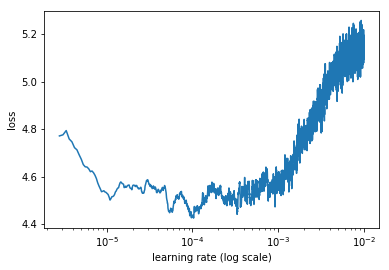

In [46]:
learner.sched.plot()

In [ ]:
learner.fit(lrs, 1, wds=wd, use_clr=(20,10), cycle_len=3)

 43%|████▎     | 10345/23794 [33:49<43:58,  5.10it/s, loss=4.49]

We save the trained model weights and separately save the encoder part of the LM model as well. This will serve as our backbone in the classification task model.

In [23]:
learner.save('lm1')

In [23]:
learner.save_encoder('lm1_enc')

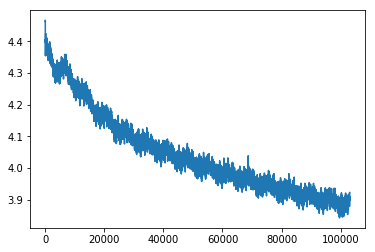

In [24]:
learner.sched.plot_loss()

## Classifier tokens

The classifier model is basically a linear layer custom head on top of the LM backbone. Setting up the classifier data is similar to the LM data setup except that we cannot use the unsup movie reviews this time.

use pd.read_csv to load in df_trn and df_val from CLAS_PATH using train.csv and test.csv

In [168]:
df_trn = pd.read_csv(CLAS_PATH/'train.csv', header=None, chunksize=chunksize)
df_val = pd.read_csv(CLAS_PATH/'test.csv', header=None, chunksize=chunksize)

re-use get_all function to create tokens and labels

In [169]:
tok_trn, trn_labels = get_all(df_trn, 1)
tok_val, val_labels = get_all(df_val, 1)

0
1
0
1


create tmp directory using pathlib. Then save the tokens and labels

In [170]:
(CLAS_PATH/'tmp').mkdir(exist_ok=True)

np.save(CLAS_PATH/'tmp'/'tok_trn.npy', tok_trn)
np.save(CLAS_PATH/'tmp'/'tok_val.npy', tok_val)

np.save(CLAS_PATH/'tmp'/'trn_labels.npy', trn_labels)
np.save(CLAS_PATH/'tmp'/'val_labels.npy', val_labels)

load the tokens

In [171]:
tok_trn = np.load(CLAS_PATH/'tmp'/'tok_trn.npy')
tok_val = np.load(CLAS_PATH/'tmp'/'tok_val.npy')

create itos and stoi  
use itos saved in LM_PATH/tmp/itos.pkl

In [172]:
itos = pickle.load((LM_PATH/'tmp'/'itos.pkl').open('rb'))
stoi = collections.defaultdict(lambda:0, {v:k for k,v in enumerate(itos)})
len(itos)

60002

convert tokens to indices

trn_clas
* numpy array
* use two list comps

val_clas
* 



In [173]:
trn_clas = np.array([[stoi[o] for o in p] for p in tok_trn])
val_clas = np.array([[stoi[o] for o in p] for p in tok_val])

save tokens to disk
* trn_ids.npy
* val_ids.npy

In [60]:
np.save(CLAS_PATH/'tmp'/'trn_ids.npy', trn_clas)
np.save(CLAS_PATH/'tmp'/'val_ids.npy', val_clas)

## Classifier

Now we can create our final model, a classifier which is really a custom linear head over our trained IMDB backbone. The steps to create the classifier model are similar to the ones for the LM.

load in data from the disk
* trn_ids.npy
* val_ids.npy

In [179]:
trn_clas = np.load(CLAS_PATH/'tmp'/'trn_ids.npy')
val_clas = np.load(CLAS_PATH/'tmp'/'val_ids.npy')

load in data from disk
* trn_labels.npy
* val_labels.npy

In [185]:
trn_labels = np.load(CLAS_PATH/'tmp'/'trn_labels.npy')


In [180]:
trn_labels = np.squeeze(np.load(CLAS_PATH/'tmp'/'trn_labels.npy'))
val_labels = np.squeeze(np.load(CLAS_PATH/'tmp'/'val_labels.npy'))

In [9]:
bptt,em_sz,nh,nl = 70,400,1150,3
vs = len(itos)
opt_fn = partial(optim.Adam, betas=(0.8, 0.99))
bs = 48

In [10]:
min_lbl = trn_labels.min()
trn_labels -= min_lbl
val_labels -= min_lbl
c=int(trn_labels.max())+1

In the classifier, unlike LM, we need to read a movie review at a time and learn to predict the it's sentiment as pos/neg. We do not deal with equal bptt size batches, so we have to pad the sequences to the same length in each batch. To create batches of similar sized movie reviews, we use a sortish sampler method invented by [@Smerity](https://twitter.com/Smerity) and [@jekbradbury](https://twitter.com/jekbradbury)

The sortishSampler cuts down the overall number of padding tokens the classifier ends up seeing.

In [11]:
trn_ds = TextDataset(trn_clas, trn_labels)
val_ds = TextDataset(val_clas, val_labels)
trn_samp = SortishSampler(trn_clas, key=lambda x: len(trn_clas[x]), bs=bs//2)
val_samp = SortSampler(val_clas, key=lambda x: len(val_clas[x]))
trn_dl = DataLoader(trn_ds, bs//2, transpose=True, num_workers=1, pad_idx=1, sampler=trn_samp)
val_dl = DataLoader(val_ds, bs, transpose=True, num_workers=1, pad_idx=1, sampler=val_samp)
md = ModelData(PATH, trn_dl, val_dl)

In [12]:
# part 1
dps = np.array([0.4, 0.5, 0.05, 0.3, 0.1])

In [13]:
dps = np.array([0.4,0.5,0.05,0.3,0.4])*0.5

In [13]:
m = get_rnn_classifer(bptt, 20*70, c, vs, emb_sz=em_sz, n_hid=nh, n_layers=nl, pad_token=1,
          layers=[em_sz*3, 50, c], drops=[dps[4], 0.1],
          dropouti=dps[0], wdrop=dps[1], dropoute=dps[2], dropouth=dps[3])

In [14]:
opt_fn = partial(optim.Adam, betas=(0.7, 0.99))

In [15]:
learn = RNN_Learner(md, TextModel(to_gpu(m)), opt_fn=opt_fn)
learn.reg_fn = partial(seq2seq_reg, alpha=2, beta=1)
learn.clip=25.
learn.metrics = [accuracy]

In [16]:
lr=3e-3
lrm = 2.6
lrs = np.array([lr/(lrm**4), lr/(lrm**3), lr/(lrm**2), lr/lrm, lr])

In [17]:
lrs=np.array([1e-4,1e-4,1e-4,1e-3,1e-2])

In [18]:
wd = 1e-7
wd = 0
learn.load_encoder('lm2_enc')

In [80]:
learn.freeze_to(-1)

In [60]:
learn.lr_find(lrs/1000)
learn.sched.plot()

A Jupyter Widget

 80%|███████▉  | 625/782 [01:39<00:24,  6.31it/s, loss=1.28] 

In [82]:
learn.fit(lrs, 1, wds=wd, cycle_len=1, use_clr=(8,3))

A Jupyter Widget

epoch      trn_loss   val_loss   accuracy                      
    0      0.365457   0.185553   0.928719  



[0.18555279, 0.9287188090884525]

In [83]:
learn.save('clas_0')

In [18]:
learn.load('clas_0')

In [86]:
learn.freeze_to(-2)

In [87]:
learn.fit(lrs, 1, wds=wd, cycle_len=1, use_clr=(8,3))

A Jupyter Widget

epoch      trn_loss   val_loss   accuracy                      
    0      0.340473   0.17319    0.933125  



[0.17319041, 0.9331253991245995]

In [88]:
learn.save('clas_1')

In [19]:
learn.load('clas_1')

In [20]:
learn.unfreeze()

In [21]:
learn.fit(lrs, 1, wds=wd, cycle_len=14, use_clr=(32,10))

A Jupyter Widget

epoch      trn_loss   val_loss   accuracy                      
    0      0.337347   0.186812   0.930782  
    1      0.284065   0.318038   0.932062                      
    2      0.246721   0.156018   0.941747                      
    3      0.252745   0.157223   0.944106                      
    4      0.24023    0.159444   0.945393                      
    5      0.210046   0.202856   0.942858                      
    6      0.212139   0.149009   0.943746                      
    7      0.21163    0.186739   0.946553                      
    8      0.186233   0.1508     0.945218                      
    9      0.176225   0.150472   0.947985                      
    10     0.198024   0.146215   0.948345                      
    11     0.20324    0.189206   0.948145                      
    12     0.165159   0.151402   0.947745                      
    13     0.165997   0.146615   0.947905                      



[0.14661488, 0.9479046703071374]

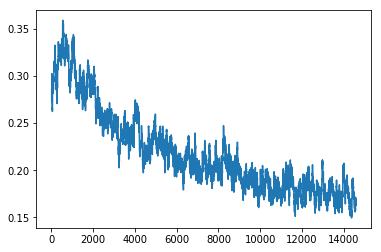

In [22]:
learn.sched.plot_loss()

In [23]:
learn.save('clas_2')

The previous state of the art result was 94.1% accuracy (5.9% error). With bidir we get 95.4% accuracy (4.6% error).

## Fin

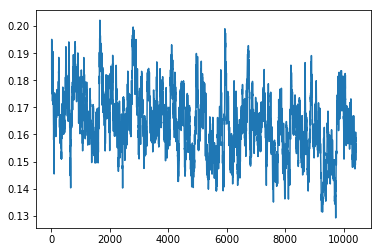

In [25]:
learn.sched.plot_loss()